# Setup
This section contains all codes and presets to setup the notebook.

In [2]:
# Reload all modules at every code execution
%load_ext autoreload
%autoreload 2

In [3]:
# Dataloader
from thenetflixstory.data_processing import load_netflixdata
df_netflix = load_netflixdata()

In [16]:
# Default Format presets
BAR_FORMATS = {'highlight':{'color':'red'},
          'deemphasize':{'color':'lightgrey'}
          }

FIGURE_FORMATS = {'figsize':(12,6)}

<p align="center">
  <img src="pics/netflix_intro_logo.avif" width="800">
  <br>
  <em>Image: From Thibault Penin on https://unsplash.com/</em>
</p>

# Netflix Unfiltered - What Content Ratings and Genres Reveal About the Platform's Evolution

## Intro - Our Research Question
Over the years, Netflix has shifted from a family-friendly catalog to a platform dominated by mature content. We explore how content rating, genre, country, and format changed - and what this reveals about its evolving strategy.

TODO: Set expectations (what trends or questions will be explored -> Lead)

## Explain the data source (Netflix dataset)
TODO... 

## Graph1 (Sven) - Growth by Age Rating
Shows how TV-MA and R-related content exploted post-2015

## Graph2 (Sven) - Composition by Rating
Confirms the shift: mature content now dominates share.


## Graph3 (Sven) Genre vs Rating
Reveals that Drama, Thriller, HOrror = mature, Kids, Family = G/PG

## Graph4 (Boris) - Top Countries by Mature Titles
TODO: Which regions are leading to shift to TV-MA?

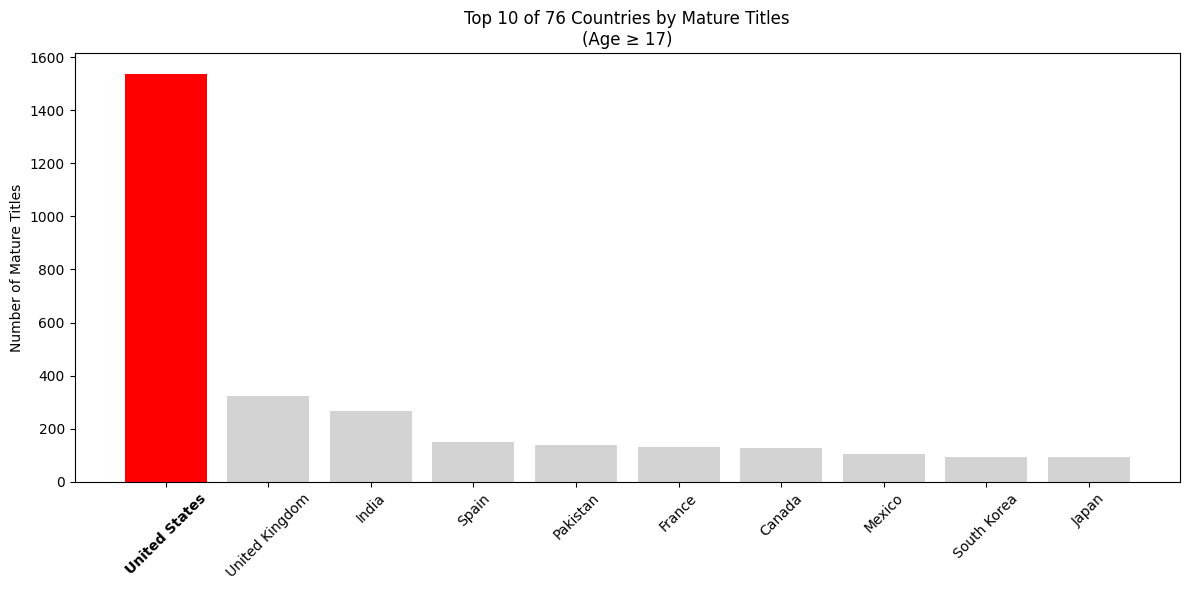

In [113]:
import pandas as pd
import matplotlib.pyplot as plt

# ---- Mature-Filter ----
AGE_FILTER = 17
TOP_N_COUNTRIES = 10

df_mature = df_netflix.query('rating_age >= @AGE_FILTER')

# ---- Länder zählen ----
country_counts = (
    df_mature['country_clean']
    .value_counts()
    .head(TOP_N_COUNTRIES)  # Top 10
)

# ---- Farben definieren ----
colors = [BAR_FORMATS['highlight']['color']] + [BAR_FORMATS['deemphasize']['color']] * (len(country_counts) - 1)

# ---- Plot ----
fig, ax = plt.subplots(**FIGURE_FORMATS)
bars = ax.bar(country_counts.index, country_counts.values, color=colors)

# ---- Titel ----
total_n_countries = len(df_mature['country_clean'].unique())
ax.set_title(
    f"Top {TOP_N_COUNTRIES} of {total_n_countries} Countries by Mature Titles\n(Age ≥ {AGE_FILTER})"
)

ax.set_xlabel("")
ax.set_ylabel("Number of Mature Titles")
ax.tick_params(axis='x', rotation=45)

# ---- Top-Country Label fett machen ----
for tick_label in ax.get_xticklabels():
    if tick_label.get_text() == country_counts.index[0]:  # erstes Land
        tick_label.set_fontweight('bold')

plt.tight_layout()
plt.show()


### TODO: 4.1 Story
- Faden überlegen, wie Chart1 (ist effektiv ein Shift passiert? Ja) -> Chart4 (Einfluss pro Land auf Netflix) verknüpft werden kann
- USA hat Netflix contentmässig auf jeden Fall sehr stark beeinflusst im Bereich Mature-Content.
- Hypothese1: Gibt es in USA Ängste von Klagen je nach COntent oder sind USA einfach generell prüder?

In [109]:
import plotly.express as px

# Datensatz filtern
min_age = 17
df_mature = df_netflix.query('rating_age >= @min_age')
df_mature_exp = df_mature.explode('genres_list')

# Nur gültige Einträge
df_mature_exp = df_mature_exp.dropna(subset=["country", "genres_list"])

# Top-Land bestimmen
country_counts = df_mature_exp['country'].value_counts()
top_country = country_counts.index[0]
total_titles = country_counts.sum()

# Anteil berechnen
country_percent = (country_counts / total_titles * 100).round(1)

# Optional: neues Label mit Anteil erstellen
df_mature_exp['country_label'] = df_mature_exp['country'].apply(
    lambda c: f"{c} ({country_percent[c]}%)" if c in country_percent else c
)

# Farbdict erstellen
color_map = {c: "rgb(220,0,0)" if c == top_country else "rgb(180,180,180)"
             for c in df_mature_exp["country"].unique()}

fig = px.treemap(
    df_mature_exp,
    path=["country_label", "genres_list"],
    color="country",
    color_discrete_map=color_map,
    title=f"Mature Titles Per Country (min. age > {min_age} years old)"
)

# Top-Country fett darstellen
fig.update_traces(
    texttemplate="%{label}",  # Label bleibt gleich
    selector=dict(type='treemap')
)

# Labels fett für das Top-Country
# Dazu kann man in df_mature_exp ein spezielles HTML-Tag verwenden
df_mature_exp['country_label_html'] = df_mature_exp['country_label'].apply(
    lambda x: f"<b>{x}</b>" if top_country in x else x
)

fig = px.treemap(
    df_mature_exp,
    path=["country_label_html", "genres_list"],
    color="country",
    color_discrete_map=color_map,
    title=f"Mature Titles Per Country (min. age ≥ {min_age} years old)"
)

fig.update_traces(
    textinfo="label+value+percent parent",
)

fig.show()


### Popcorn or Popporn?
If you search the Netflix database for the keyword “sex,” a total of 18 titles appear, all of which are classified under harmless genres such as comedies, dramas, reality TV, etc. Interested readers should note at this point that there is a significant difference between “mature content” and “adult content.” The latter category does not seem to fit with Netflix's strategy and, interestingly, is not offered at all.

### On the trail of explicit language, sex, and dark humor
Let's search for well-known titles that may be US mature content but are rated FSK>18.
The search for often ambiguous animated films such as “South Park,” but also "Deadpool" or “The Wolf of Wall Street” are not even included in the Netflix database.

A quick search for suspicious movie titles then gives us the following hits:
| Title                         | US-Rating (MAA)                  | FSK-Rating |
|-------------------------------|----------------------------------|------------|
| Zack and Miri Make a Porno    | R - Restricted Mature/Adult      | FSK-16     |
| American Pie 9: Girls' Rules  | R - Restricted Mature/Adult      | FSK-15     |
| Superbad                      | R - Restricted Mature/Adult      | FSK-16     |
| ...                           | ...                              | ...        |

(R* = ages 17 and up, only permitted with parents)


This shows that...  
a) on the one hand, Titles in the Netflix database are classified using a unified, predominantly US-oriented rating scheme rather than the original regional rating systems.  
b) Within a unified, US-oriented rating framework, US comedy titles are classified as non-youth-rated significantly more often than comparable titles from other countries. This suggests that either US comedies more frequently contain elements that trigger restrictive classifications, or that the rating system is particularly sensitive to stylistic features prevalent in US comedy.


This pattern may contribute to the perception of a paradox between restrictive classification practices and the prevalence of mature-themed comedy in US productions: **hypocritical prudery is refuted by reality.**. However, this interpretation goes beyond what can be directly inferred from rating data alone.


In [103]:
candidate_titles = [ #friendly provided by ChatGPT for this purpose
    "superbad",
    "40-year-old virgin",
    "40 year old virgin",
    "american pie",
    "wedding crashers",
    "knocked up",
    "hall pass",
    "forgetting sarah marshall",
    "zack and miri",
    "american wedding",
    "american pie 2"
]

pattern = "|".join(candidate_titles)

df_candidates = df_netflix[
    df_netflix['title']
    .str.lower()
    .str.contains(pattern, regex=True, na=False)
]
df_candidates[['title','rating','country']]

,title,rating,country
988,Zack and Miri Make a Porno,R,United States
1612,American Pie 9: Girls' Rules,R,United States
5974,Superbad,R,United States


Prozentuale Mature-Titel nach Land und Genre:


/tmp/ipykernel_26077/1387983396.py:18: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/tmp/ipykernel_26077/1387983396.py:18: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/tmp/ipykernel_26077/1387983396.py:18: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `incl

,Dramas,Independent Movies,Comedies
Other countries,46.3,63.1,35.2
United States,58.6,81.9,39.1


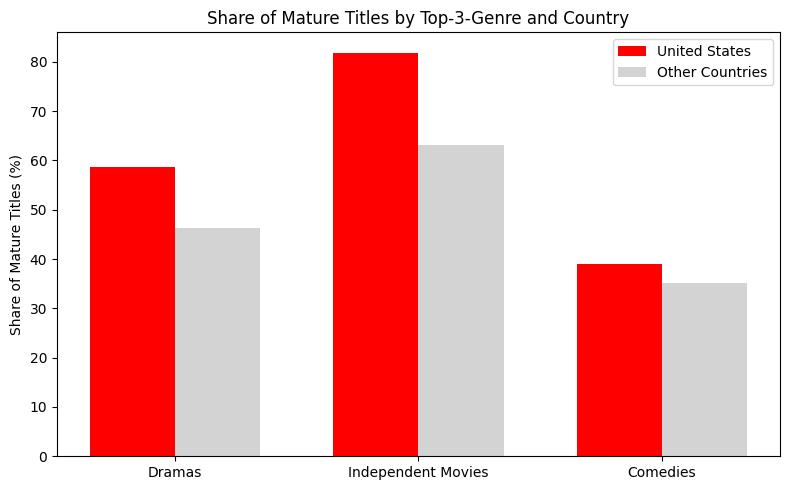

In [125]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Genres of interest
genres_of_interest = ['Dramas', 'Independent Movies', 'Comedies']

# Flags für jedes Genre
for genre in genres_of_interest:
    df_netflix[genre] = df_netflix['genres_list'].apply(lambda g: genre in g if isinstance(g, list) else False)

df_netflix['is_mature'] = df_netflix['rating_age'] >= 17
df_netflix['is_us'] = df_netflix['country_clean'] == 'United States'

# Aggregation: Anteil Mature pro Land und Genre
summary = {}
for genre in genres_of_interest:
    summary[genre] = df_netflix.groupby('is_us').apply(
        lambda x: (x[genre] & x['is_mature']).sum() / x[genre].sum() if x[genre].sum() > 0 else 0
    )

summary = pd.DataFrame(summary)
summary.index = ['Other countries', 'United States']
summary_percent = (summary * 100).round(1)

print("Prozentuale Mature-Titel nach Land und Genre:")
display(summary_percent)

# Plot: je Genre eine Gruppe, zwei Bars pro Genre
n_genres = len(genres_of_interest)
x = np.arange(n_genres)
width = 0.35

fig, ax = plt.subplots(figsize=(8,5))

# Farben setzen
ax.bar(x - width/2, summary_percent.loc['United States'], width, label='United States', color='red')
ax.bar(x + width/2, summary_percent.loc['Other countries'], width, label='Other Countries', color='lightgrey')

ax.set_ylabel('Share of Mature Titles (%)')
ax.set_title('Share of Mature Titles by Top-3-Genre and Country')
ax.set_xticks(x)
ax.set_xticklabels(genres_of_interest)
ax.legend()
plt.tight_layout()
plt.show()


## Graph5 (Boris) - Runtimes by Age Rating
Mature titles tend to be longer, especially TV shows.

## Graph6 (Elias) - Genre Popularity by Country
What genres are dominant in U.S., India, UK, Japan?

## TODO: Conclusion
a. Recap key Inisghts. Do not introduce new data - just synthesize
    
Zwischen 2010 und 2024 hat sich das Netflix-Angebot nicht nur mengenmäßig erweitert, sondern auch inhaltlich verändert. Die folgende Grafik zeigt die Entwicklung der Veröffentlichungen nach Altersfreigabe über die Jahre.
Bis etwa 2015 war die Verteilung relativ ausgewogen. Danach jedoch nimmt die Anzahl an Inhalten mit der Altersfreigabe TV-MA und R deutlich zu — parallel zur starken Zunahme an Eigenproduktionen.
Spätestens ab 2020 dominiert TV-MA das Angebot, während familienfreundliche Titel zahlenmäßig stagnieren.
Dieser Wandel ist Ausdruck einer gezielten Strategie: Netflix hat sich mit seinem Publikum weiterentwickelt. Der Chart legt damit das zeitliche Fundament für die folgenden Analysen zu Genre, Ländern und Content-Struktur.